In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web

import datetime

## Import Data

In [2]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2019, 1, 1)

df = web.DataReader("TSLA", 'yahoo', start, end)
display(df.head())
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,29.500000,27.650000,28.940001,28.080000,928100,28.080000
2012-01-04,28.670000,27.500000,28.209999,27.709999,630100,27.709999
2012-01-05,27.930000,26.850000,27.760000,27.120001,1005500,27.120001
2012-01-06,27.790001,26.410000,27.200001,26.910000,986300,26.910000
2012-01-09,27.490000,26.120001,27.000000,27.250000,897000,27.250000


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,314.500000,295.200012,313.500000,295.390015,5559900,295.390015
2018-12-26,326.970001,294.089996,300.000000,326.089996,8163100,326.089996
2018-12-27,322.170013,301.500000,319.839996,316.130005,8575100,316.130005
2018-12-28,336.239990,318.410004,323.100006,333.869995,9939000,333.869995
2018-12-31,339.209991,325.260010,337.790009,332.799988,6302300,332.799988


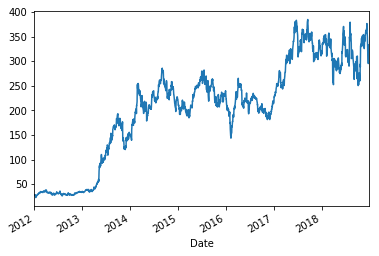

In [3]:
df["Adj Close"].plot();

## Preprocess Data

I will train models to predict the next day's return - calculated from the adjusted close price - given a series of data in a trailing window. I will test the models on a timeseries holdout. This means I will need to do the following:

1. Calculate the returns.
2. Reshape the data so that for each date I want to predict, there are columns representing the returns from previous dates in the trailing window.
3. Choose a holdout at date and split the data into that from before and that from after the date.

,High,Low,Open,Close,Volume,Adj Close,return
Date,,,,,,,
2012-01-03,29.500000,27.650000,28.940001,28.080000,928100,28.080000,NaN
2012-01-04,28.670000,27.500000,28.209999,27.709999,630100,27.709999,-0.013177
2012-01-05,27.930000,26.850000,27.760000,27.120001,1005500,27.120001,-0.021292
2012-01-06,27.790001,26.410000,27.200001,26.910000,986300,26.910000,-0.007743
2012-01-09,27.490000,26.120001,27.000000,27.250000,897000,27.250000,0.012635


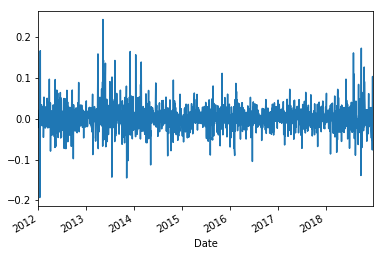

In [4]:
df["return"] = df["Adj Close"].pct_change()
display(df.head())
df["return"].plot();

In [5]:
temp = df.copy()

for window in range(1, 11):
    shifted = temp.shift(window)
    shifted.columns = [x + "_" + str(window) for x in temp.columns]
    
    df = pd.concat((df, shifted), axis=1)
df = df.dropna()
df.head()

,High,Low,Open,Close,Volume,Adj Close,return,High_1,Low_1,Open_1,Close_1,Volume_1,Adj Close_1,return_1,High_2,Low_2,Open_2,Close_2,Volume_2,Adj Close_2,return_2,High_3,Low_3,Open_3,Close_3,Volume_3,Adj Close_3,return_3,High_4,Low_4,Open_4,Close_4,Volume_4,Adj Close_4,return_4,High_5,Low_5,Open_5,Close_5,Volume_5,Adj Close_5,return_5,High_6,Low_6,Open_6,Close_6,Volume_6,Adj Close_6,return_6,High_7,Low_7,Open_7,Close_7,Volume_7,Adj Close_7,return_7,High_8,Low_8,Open_8,Close_8,Volume_8,Adj Close_8,return_8,High_9,Low_9,Open_9,Close_9,Volume_9,Adj Close_9,return_9,High_10,Low_10,Open_10,Close_10,Volume_10,Adj Close_10,return_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-19,27.740000,26.610001,27.190001,26.760000,1246300,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635,27.790001,26.410000,27.200001,26.910000,986300.0,26.910000,-0.007743,27.930000,26.850000,27.760000,27.120001,1005500.0,27.120001,-0.021292,28.670000,27.500000,28.209999,27.709999,630100.0,27.709999,-0.013177
2012-01-20,27.000000,26.400000,26.900000,26.600000,662300,26.600000,-0.005979,27.740000,26.610001,27.190001,26.760000,1246300.0,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635,27.790001,26.410000,27.200001,26.910000,986300.0,26.910000,-0.007743,27.930000,26.850000,27.760000,27.120001,1005500.0,27.120001,-0.021292
2012-01-23,27.209999,26.600000,26.809999,26.770000,594600,26.770000,0.006391,27.000000,26.400000,26.900000,26.600000,662300.0,26.600000,-0.005979,27.740000,26.610001,27.190001,26.760000,1246300.0,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635,27.790001,26.410000,27.200001,26.910000,986300.0,26.910000,-0.007743
2012-01-24,27.680000,26.440001,26.629999,27.420000,858000,27.420000,0.024281,27.209999,26.600000,26.809999,26.770000,594600.0,26.770000,0.006391,27.000000,26.400000,26.900000,26.600000,662300.0,26.600000,-0.005979,27.740000,26.610001,27.190001,26.760000,1246300.0,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635
2012-01-25,28.010000,27.049999,27.270000,27.969999,611200,27.969999,0.020058,27.680000,26.440001,26.629999,27.420000,858000.0,27.420000,0.024281,27.209999,26.600000,26.809999,26.770000,594600.0,26.770000,0.006391,27.000000,

In [6]:
df_train = df[df.index < "2018-01-01"]
df_test = df[df.index >= "2018-01-01"]

display(df_train.tail())
df_test.head()

,High,Low,Open,Close,Volume,Adj Close,return,High_1,Low_1,Open_1,Close_1,Volume_1,Adj Close_1,return_1,High_2,Low_2,Open_2,Close_2,Volume_2,Adj Close_2,return_2,High_3,Low_3,Open_3,Close_3,Volume_3,Adj Close_3,return_3,High_4,Low_4,Open_4,Close_4,Volume_4,Adj Close_4,return_4,High_5,Low_5,Open_5,Close_5,Volume_5,Adj Close_5,return_5,High_6,Low_6,Open_6,Close_6,Volume_6,Adj Close_6,return_6,High_7,Low_7,Open_7,Close_7,Volume_7,Adj Close_7,return_7,High_8,Low_8,Open_8,Close_8,Volume_8,Adj Close_8,return_8,High_9,Low_9,Open_9,Close_9,Volume_9,Adj Close_9,return_9,High_10,Low_10,Open_10,Close_10,Volume_10,Adj Close_10,return_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-22,330.920013,324.820007,329.510010,325.200012,4215800,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929,346.730011,337.579987,344.899994,338.869995,5476200.0,338.869995,-0.013335,343.899994,335.760010,342.040009,343.450012,6933200.0,343.450012,0.016455,347.440002,336.899994,341.010010,337.890015,5799900.0,337.890015,-0.003362,344.220001,336.500000,340.929993,339.029999,6221500.0,339.029999,-0.005865,341.440002,330.029999,330.450012,341.029999,8733200.0,341.029999,0.036849,329.010010,313.750000,314.630005,328.910004,7938000.0,328.910004,0.043728,316.980011,311.260010,314.600006,315.130005,3468500.0,315.130005,0.012498
2017-12-26,323.940002,316.579987,323.829987,317.290009,4378400,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929,346.730011,337.579987,344.899994,338.869995,5476200.0,338.869995,-0.013335,343.899994,335.760010,342.040009,343.450012,6933200.0,343.450012,0.016455,347.440002,336.899994,341.010010,337.890015,5799900.0,337.890015,-0.003362,344.220001,336.500000,340.929993,339.029999,6221500.0,339.029999,-0.005865,341.440002,330.029999,330.450012,341.029999,8733200.0,341.029999,0.036849,329.010010,313.750000,314.630005,328.910004,7938000.0,328.910004,0.043728
2017-12-27,317.679993,310.750000,316.000000,311.640015,4712100,311.640015,-0.017807,323.940002,316.579987,323.829987,317.290009,4378400.0,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929,346.730011,337.579987,344.899994,338.869995,5476200.0,338.869995,-0.013335,343.899994,335.760010,342.040009,343.450012,6933200.0,343.450012,0.016455,347.440002,336.899994,341.010010,337.890015,5799900.0,337.890015,-0.003362,344.220001,336.500000,340.929993,339.029999,6221500.0,339.029999,-0.005865,341.440002,330.029999,330.450012,341.029999,8733200.0,341.029999,0.036849
2017-12-28,315.820007,309.540009,311.750000,315.359985,4316300,315.359985,0.011937,317.679993,310.750000,316.000000,311.640015,4712100.0,311.640015,-0.017807,323.940002,316.579987,323.829987,317.290009,4378400.0,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929,346.730011,337.579987,344.899994,338.869995,5476200.0,338.869995,-0.013335,343.899994,335.760010,342.040009,343.450012,6933200.0,343.450012,0.016455,347.440002,336.899994,341.010010,337.890015,5799900.0,337.890015,-0.003362,344.220001,336.500000,340.929993,339.029

,High,Low,Open,Close,Volume,Adj Close,return,High_1,Low_1,Open_1,Close_1,Volume_1,Adj Close_1,return_1,High_2,Low_2,Open_2,Close_2,Volume_2,Adj Close_2,return_2,High_3,Low_3,Open_3,Close_3,Volume_3,Adj Close_3,return_3,High_4,Low_4,Open_4,Close_4,Volume_4,Adj Close_4,return_4,High_5,Low_5,Open_5,Close_5,Volume_5,Adj Close_5,return_5,High_6,Low_6,Open_6,Close_6,Volume_6,Adj Close_6,return_6,High_7,Low_7,Open_7,Close_7,Volume_7,Adj Close_7,return_7,High_8,Low_8,Open_8,Close_8,Volume_8,Adj Close_8,return_8,High_9,Low_9,Open_9,Close_9,Volume_9,Adj Close_9,return_9,High_10,Low_10,Open_10,Close_10,Volume_10,Adj Close_10,return_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,322.109985,311.000000,312.000000,320.529999,4352200,320.529999,0.029484,316.410004,310.000000,316.179993,311.350006,3777200.0,311.350006,-0.012716,315.820007,309.540009,311.750000,315.359985,4316300.0,315.359985,0.011937,317.679993,310.750000,316.000000,311.640015,4712100.0,311.640015,-0.017807,323.940002,316.579987,323.829987,317.290009,4378400.0,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929,346.730011,337.579987,344.899994,338.869995,5476200.0,338.869995,-0.013335,343.899994,335.760010,342.040009,343.450012,6933200.0,343.450012,0.016455
2018-01-03,325.250000,315.549988,321.000000,317.250000,4521500,317.250000,-0.010233,322.109985,311.000000,312.000000,320.529999,4352200.0,320.529999,0.029484,316.410004,310.000000,316.179993,311.350006,3777200.0,311.350006,-0.012716,315.820007,309.540009,311.750000,315.359985,4316300.0,315.359985,0.011937,317.679993,310.750000,316.000000,311.640015,4712100.0,311.640015,-0.017807,323.940002,316.579987,323.829987,317.290009,4378400.0,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929,346.730011,337.579987,344.899994,338.869995,5476200.0,338.869995,-0.013335
2018-01-04,318.549988,305.679993,312.869995,314.619995,9946300,314.619995,-0.008290,325.250000,315.549988,321.000000,317.250000,4521500.0,317.250000,-0.010233,322.109985,311.000000,312.000000,320.529999,4352200.0,320.529999,0.029484,316.410004,310.000000,316.179993,311.350006,3777200.0,311.350006,-0.012716,315.820007,309.540009,311.750000,315.359985,4316300.0,315.359985,0.011937,317.679993,310.750000,316.000000,311.640015,4712100.0,311.640015,-0.017807,323.940002,316.579987,323.829987,317.290009,4378400.0,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.980011,5953800.0,328.980011,-0.006403,341.489990,330.299988,340.260010,331.100006,6825000.0,331.100006,-0.022929
2018-01-05,317.239990,312.000000,316.619995,316.579987,4591200,316.579987,0.006230,318.549988,305.679993,312.869995,314.619995,9946300.0,314.619995,-0.008290,325.250000,315.549988,321.000000,317.250000,4521500.0,317.250000,-0.010233,322.109985,311.000000,312.000000,320.529999,4352200.0,320.529999,0.029484,316.410004,310.000000,316.179993,311.350006,3777200.0,311.350006,-0.012716,315.820007,309.540009,311.750000,315.359985,4316300.0,315.359985,0.011937,317.679993,310.750000,316.000000,311.640015,4712100.0,311.640015,-0.017807,323.940002,316.579987,323.829987,317.290009,4378400.0,317.290009,-0.024324,330.920013,324.820007,329.510010,325.200012,4215800.0,325.200012,-0.019478,333.739990,327.209991,329.589996,331.660004,4385200.0,331.660004,0.008146,333.100006,325.040009,332.690002,328.98

In [7]:
X_train, y_train = df_train.drop("return", axis=1), df_train["return"]
X_test, y_test = df_test.drop("return", axis=1), df_test["return"]

display(X_train.head())
y_train.head()

,High,Low,Open,Close,Volume,Adj Close,High_1,Low_1,Open_1,Close_1,Volume_1,Adj Close_1,return_1,High_2,Low_2,Open_2,Close_2,Volume_2,Adj Close_2,return_2,High_3,Low_3,Open_3,Close_3,Volume_3,Adj Close_3,return_3,High_4,Low_4,Open_4,Close_4,Volume_4,Adj Close_4,return_4,High_5,Low_5,Open_5,Close_5,Volume_5,Adj Close_5,return_5,High_6,Low_6,Open_6,Close_6,Volume_6,Adj Close_6,return_6,High_7,Low_7,Open_7,Close_7,Volume_7,Adj Close_7,return_7,High_8,Low_8,Open_8,Close_8,Volume_8,Adj Close_8,return_8,High_9,Low_9,Open_9,Close_9,Volume_9,Adj Close_9,return_9,High_10,Low_10,Open_10,Close_10,Volume_10,Adj Close_10,return_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-19,27.740000,26.610001,27.190001,26.760000,1246300,26.760000,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635,27.790001,26.410000,27.200001,26.910000,986300.0,26.910000,-0.007743,27.930000,26.850000,27.760000,27.120001,1005500.0,27.120001,-0.021292,28.670000,27.500000,28.209999,27.709999,630100.0,27.709999,-0.013177
2012-01-20,27.000000,26.400000,26.900000,26.600000,662300,26.600000,27.740000,26.610001,27.190001,26.760000,1246300.0,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635,27.790001,26.410000,27.200001,26.910000,986300.0,26.910000,-0.007743,27.930000,26.850000,27.760000,27.120001,1005500.0,27.120001,-0.021292
2012-01-23,27.209999,26.600000,26.809999,26.770000,594600,26.770000,27.000000,26.400000,26.900000,26.600000,662300.0,26.600000,-0.005979,27.740000,26.610001,27.190001,26.760000,1246300.0,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635,27.790001,26.410000,27.200001,26.910000,986300.0,26.910000,-0.007743
2012-01-24,27.680000,26.440001,26.629999,27.420000,858000,27.420000,27.209999,26.600000,26.809999,26.770000,594600.0,26.770000,0.006391,27.000000,26.400000,26.900000,26.600000,662300.0,26.600000,-0.005979,27.740000,26.610001,27.190001,26.760000,1246300.0,26.760000,-0.001865,26.879999,26.250000,26.690001,26.809999,1260200.0,26.809999,0.007895,27.340000,26.410000,26.620001,26.600000,4651600.0,26.600000,0.167179,28.500000,22.639999,28.400000,22.790001,5500400.0,22.790001,-0.193274,28.620001,27.809999,28.480000,28.250000,729300.0,28.250000,0.000708,28.379999,27.299999,27.620001,28.230000,672300.0,28.230000,0.022085,27.760000,27.250000,27.440001,27.620001,671800.0,27.620001,0.013578,27.490000,26.120001,27.000000,27.250000,897000.0,27.250000,0.012635
2012-01-25,28.010000,27.049999,27.270000,27.969999,611200,27.969999,27.680000,26.440001,26.629999,27.420000,858000.0,27.420000,0.024281,27.209999,26.600000,26.809999,26.770000,594600.0,26.770000,0.006391,27.000000,26.400000,26.900000,26.600000,662300.0,26.600000,-0.005

Date
2012-01-19   -0.001865
2012-01-20   -0.005979
2012-01-23    0.006391
2012-01-24    0.024281
2012-01-25    0.020058
Name: return, dtype: float64

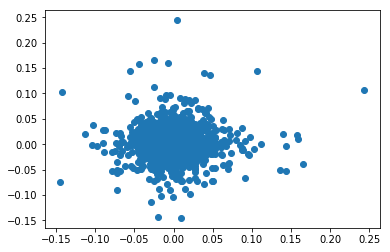

In [8]:
plt.plot(X_train["return_1"], y_train, 'o');

## Train Models

I will try out the following regression models:

- Ridge Regression
- K Nearest Neighbors Regression
- Gradient Boosting Tree Regression

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

from yellowbrick.regressor import PredictionError

In [10]:
ridge_model = RidgeCV()
ridge_model.fit(X_train, y_train)

ridge_preds_train, ridge_preds_test = ridge_model.predict(X_train), ridge_model.predict(X_test)


print("Training R2:", ridge_model.score(X_train, y_train))
print("Training MSE:", mean_squared_error(ridge_preds_train, y_train))
print("\nHoldout R2:", ridge_model.score(X_test, y_test))
print("Holdout MSE:", mean_squared_error(ridge_preds_test, y_test))

Training R2: 0.4230783162352935
Training MSE: 0.0005144557279212906

Holdout R2: 0.23678879680503584
Holdout MSE: 0.00103461572951129


In [11]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

knn_preds_train, knn_preds_test = knn_model.predict(X_train), knn_model.predict(X_test)


print("Training R2:", knn_model.score(X_train, y_train))
print("Training MSE:", mean_squared_error(knn_preds_train, y_train))
print("\nHoldout R2:", knn_model.score(X_test, y_test))
print("Holdout MSE:", mean_squared_error(knn_preds_test, y_test))

Training R2: 0.2538821056298345
Training MSE: 0.0006653322890526896

Holdout R2: -0.18230946319120056
Holdout MSE: 0.0016027489673198455


In [12]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

gb_preds_train, gb_preds_test = gb_model.predict(X_train), gb_model.predict(X_test)


print("Training R2:", gb_model.score(X_train, y_train))
print("Training MSE:", mean_squared_error(gb_preds_train, y_train))
print("\nHoldout R2:", gb_model.score(X_test, y_test))
print("Holdout MSE:", mean_squared_error(gb_preds_test, y_test))

Training R2: 0.6111011729646132
Training MSE: 0.0003467909679606073

Holdout R2: -0.3101628753390919
Holdout MSE: 0.001776068162224414


It seems like the simplest model, RidgeCV, overfits the least on the training set. Note that when the holdout test set is strictly from a different period in time, instead of being sampled randomly from the full data, it's very likely that the data is no longer distributed in the same way, and so much more performance degradation from training to testing is to be expected. This is much preferrable to not accounting for lookahead bias and getting an over-optimistic estimate of model performance.

## Visualize Predictions

To convert predicted returns back to predicted prices, I will need to multiply the previous date's price by 1 plus the predicted return.

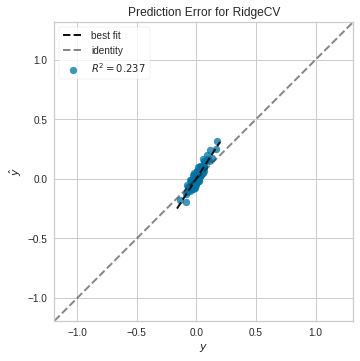

In [13]:
vis_ridge = PredictionError(ridge_model)

vis_ridge.fit(X_train, y_train) 
vis_ridge.score(X_test, y_test)
vis_ridge.poof()    

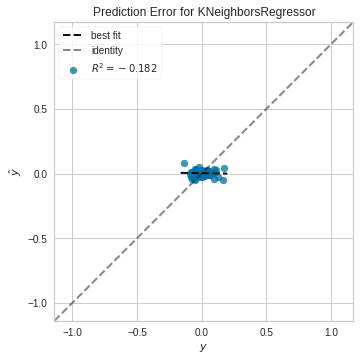

In [14]:
vis_knn = PredictionError(knn_model)

vis_knn.fit(X_train, y_train) 
vis_knn.score(X_test, y_test)
vis_knn.poof()  

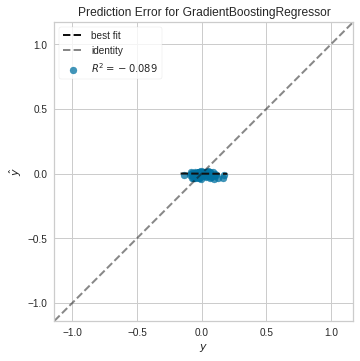

In [15]:
gb_knn = PredictionError(gb_model)

gb_knn.fit(X_train, y_train) 
gb_knn.score(X_test, y_test)
gb_knn.poof()  

In [16]:
df_testvis = df_test.copy()
df_testvis["ridge_pred"], df_testvis["knn_pred"], df_testvis["gb_pred"] = ridge_preds_test, knn_preds_test, gb_preds_test

df_testvis["ridge_pred_close"] = df_testvis["Adj Close_1"] * (1 + df_testvis["ridge_pred"])
df_testvis["knn_pred_close"] = df_testvis["Adj Close_1"] * (1 + df_testvis["knn_pred"])
df_testvis["gb_pred_close"] = df_testvis["Adj Close_1"] * (1 + df_testvis["gb_pred"])

df_testvis = df_testvis[["Adj Close", "ridge_pred_close", "knn_pred_close", "gb_pred_close"]]
df_testvis.head()

,Adj Close,ridge_pred_close,knn_pred_close,gb_pred_close
Date,,,,
2018-01-02,320.529999,321.548611,313.019934,311.871615
2018-01-03,317.250000,313.641291,320.959308,320.127063
2018-01-04,314.619995,315.749143,322.244937,317.018064
2018-01-05,316.579987,322.218004,315.982611,314.885726
2018-01-08,336.410004,348.551278,312.048275,318.760992


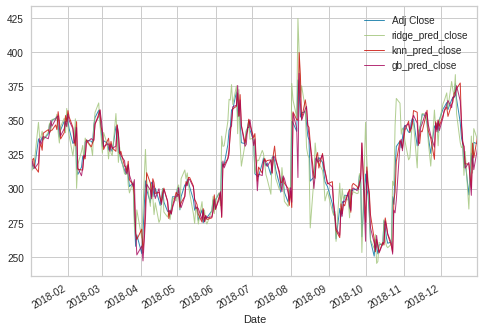

In [17]:
df_testvis.plot(alpha=0.8, linewidth=1);